In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

In [3]:
# Load the Brent oil data
column_names = ["Date", "OilPrice"]
brent_data = pd.read_excel("https://www.eia.gov/dnav/pet/hist_xls/RBRTEd.xls", sheet_name=1, skiprows=4, engine='xlrd', names=column_names)
brent_data.dropna(inplace=True)  # Drop missing values if any
brent_data['Date'] = pd.to_datetime(brent_data['Date'])
brent_data.set_index('Date', inplace=True)


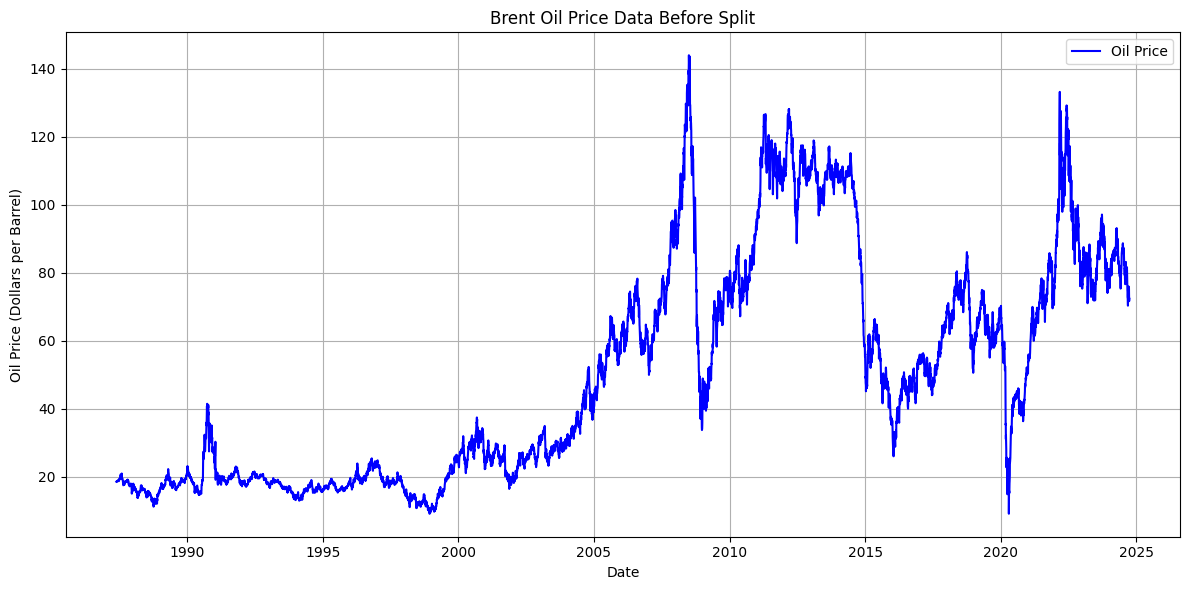

In [4]:
# Plot original data
plt.figure(figsize=(12, 6))
plt.plot(brent_data.index, brent_data['OilPrice'], label='Oil Price', color='blue')
plt.xlabel('Date')
plt.ylabel('Oil Price (Dollars per Barrel)')
plt.title('Brent Oil Price Data Before Split')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
brent_data['normalized_oil_prices'] = scaler.fit_transform(brent_data[['OilPrice']])

In [6]:
# Train-test split
split_date = pd.to_datetime("2010-01-01")
cutoff_date = pd.to_datetime("2023-01-01")

train_data = brent_data.loc[split_date:cutoff_date]['normalized_oil_prices']
test_data = brent_data.loc[cutoff_date:]['normalized_oil_prices']

In [7]:
# Function to create sequences for LSTM input
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
    return np.array(sequences)

# Define sequence length (e.g., 60 days)
seq_length = 60
train_sequences = create_sequences(train_data.values, seq_length)
test_sequences = create_sequences(test_data.values, seq_length)


In [8]:
# Split sequences into input (X) and output (y)
X_train = train_sequences[:, :-1]
y_train = train_sequences[:, -1]

X_test = test_sequences[:, :-1]
y_test = test_sequences[:, -1]

# Reshape for LSTM input [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [10]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))  # Dropout to prevent overfitting
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Output layer
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 14s 62ms/step - loss: 0.0269 - val_loss: 3.3117e-04
Epoch 2/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - loss: 0.0024 - val_loss: 3.1826e-04
Epoch 3/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 0.0017 - val_loss: 3.8163e-04
Epoch 4/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - loss: 0.0016 - val_loss: 3.4132e-04
Epoch 5/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0013 - val_loss: 5.8952e-04
Epoch 6/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - loss: 0.0012 - val_loss: 3.5570e-04
Epoch 7/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 8.6058e-04 - val_loss: 4.5026e-04
Epoch 8/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 9.4395e-04 - val_loss: 7.7703e-04
Epoch 9/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - loss: 8.6207e-04 - val_loss: 2.7606e-04
Epoch 10/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - loss: 7.6562e-04 - val_loss: 5.0051e-04
Epoch 11/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - loss: 7.8839e-

In [13]:
# Predict for a specific period: 30 days from the test split
n_days = 30  # Number of days to predict
X_test_30 = X_test[:n_days]  # Take the first 30 days of test data
y_test_30 = y_test[:n_days]  # Take the actual values for the same period

# Predict using the trained LSTM model
predicted_oil_prices_30 = model.predict(X_test_30)

# Inverse transform to get back to the original oil price values
predicted_oil_prices_30 = scaler.inverse_transform(predicted_oil_prices_30)
real_oil_prices_30 = scaler.inverse_transform(y_test_30.reshape(-1, 1))

# Calculate RMSE for the 30-day period
rmse_30 = np.sqrt(mean_squared_error(real_oil_prices_30, predicted_oil_prices_30))
print(f'Root Mean Squared Error for 30 days: {rmse_30}')

# # Plot the real vs predicted oil prices for the 30-day period
# plt.figure(figsize=(12, 6))
# plt.plot(test_dates[seq_length:seq_length + n_days], real_oil_prices_30, label='Real Oil Prices', color='blue')
# plt.plot(test_dates[seq_length:seq_length + n_days], predicted_oil_prices_30, label='Predicted Oil Prices', color='red')
# plt.xlabel('Date')
# plt.ylabel('Oil Price (Dollars per Barrel)')
# plt.title('Brent Oil Price Prediction (30 Days)')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Root Mean Squared Error for 30 days: 3.6984509010671767


In [11]:
# Predict on test data
predicted_oil_prices = model.predict(X_test)
predicted_oil_prices = scaler.inverse_transform(predicted_oil_prices)  # Rescale to original values

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(scaler.inverse_transform(y_test.reshape(-1, 1)), predicted_oil_prices))
print(f'Root Mean Squared Error: {rmse}')

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
Root Mean Squared Error: 3.065359223416861
